# Gradient boosting machine
**Important**: Change the kernel to *PROJECT_NAME local*. You can do this from the *Kernel* menu under *Change kernel*.

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import pickle
import os
import scipy.stats as st
from itertools import combinations

In [ ]:
from azureml.logging import get_azureml_logger
run_logger = get_azureml_logger()
run_logger.log('amlrealworld.timeseries.gbm','true')

In [3]:
model_name = "gbm"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(os.path.join(aml_dir, 'nyc_demand_train.csv'), parse_dates=['timeStamp'])

Use randomised search to find optimal hyperparameters. This model will take about 5 minutes to train. The quality of the solution may be improved by increasing the number of iterations in the randomized search, at the expense of increased training times.

In [4]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [5]:
regr = GradientBoostingRegressor()
tscv = TimeSeriesSplit(n_splits=3)

In [6]:
param_dist = {'n_estimators': st.randint(3, 100),
                'learning_rate': st.uniform(0.01, 0.1),
                'max_depth': range(2,31),
                'min_samples_leaf': st.randint(1, 100),
                'min_samples_split': st.randint(2, 50),
                'max_features': range(3,X.shape[1]+1),
                'subsample': st.uniform(0.1, 0.9)
             }
regr_cv = RandomizedSearchCV(estimator=regr,
            param_distributions=param_dist,
            n_iter=50,
            cv=tscv,
            scoring='neg_mean_squared_error',
            verbose=2,
            n_jobs=-1)
regr_pipe = Pipeline([('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.0min finished


Pipeline(steps=[('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(n_splits=3), error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_im...it=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2))])

In [7]:
with open(os.path.join(aml_dir, model_name + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)

Cross validation results

In [8]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score', inplace=True)
cv_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
25,36.646686,0.107001,-2682.683116,-475.188836,0.0893121,30,17,5,39,73,...,-3704.744495,-596.486382,-2156.206546,-443.950909,-2187.098307,-385.129217,24.021242,0.014837,722.816562,89.068583
47,26.072005,0.065179,-3129.365072,-631.282753,0.100464,25,14,10,20,42,...,-4364.161987,-737.863908,-2429.509127,-616.880984,-2594.424102,-539.103366,15.081597,0.014282,875.725148,81.780179
35,14.201516,0.065501,-3836.725607,-2644.898487,0.080473,19,17,31,38,72,...,-6292.536425,-3568.500115,-2710.811495,-2460.051155,-2506.828902,-1906.144191,9.636239,0.009336,1738.516092,691.126234
31,15.909298,0.052167,-3887.501952,-2433.697468,0.104576,22,17,72,25,56,...,-6370.149330,-3354.395844,-2685.983589,-2186.094888,-2606.372936,-1760.601672,9.787633,0.007134,1755.797629,673.807710
8,10.766570,0.053835,-4654.305067,-3554.887272,0.06553,11,15,23,13,58,...,-7282.983614,-4587.941411,-3289.583189,-3294.415428,-3390.348397,-2782.304976,6.988101,0.004644,1859.211587,759.809152


Inspect the pairwise distribution of cross validation scores. Darker shades of blue indicate superior performance while the red star represents the optimal solution found.

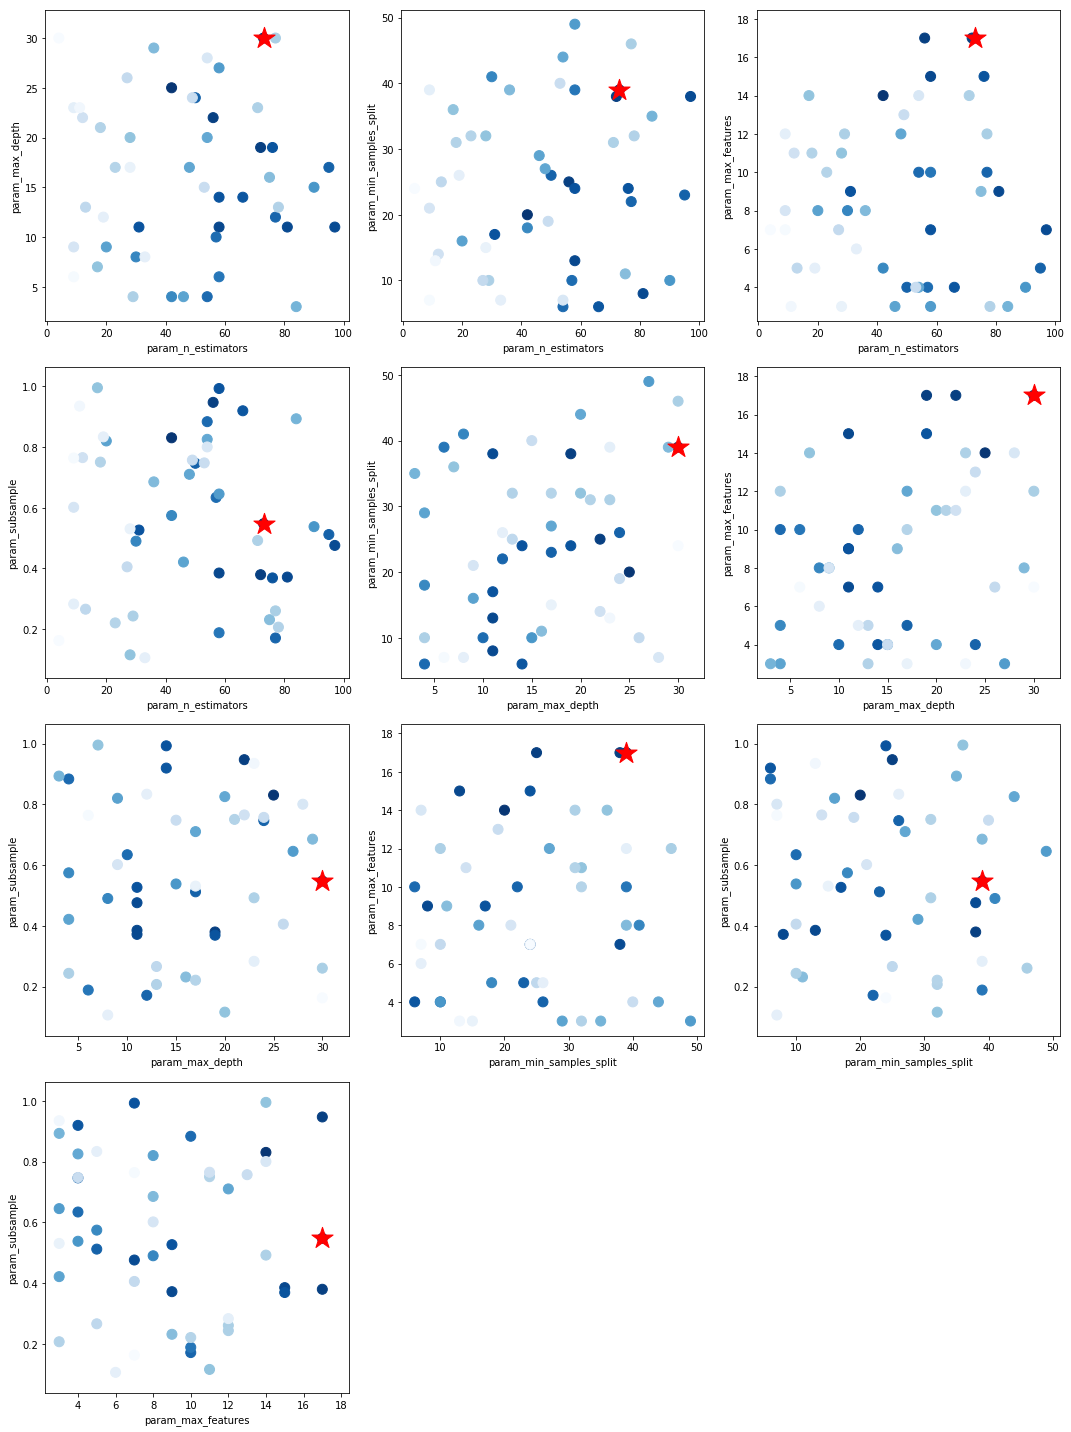

In [9]:
params = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_max_features', 'param_subsample']
gs = gridspec.GridSpec(4,3)
fig = plt.figure(figsize=(15, 20), tight_layout=True)
plt_best = cv_results.head(1)
for idx, params in enumerate(combinations(params, 2)):
    ax = fig.add_subplot(gs[idx])
    plt.scatter(cv_results[params[0]], cv_results[params[1]], c=-np.log(-cv_results['mean_test_score']), s=100, cmap="Blues")
    plt.scatter(plt_best[params[0]], plt_best[params[1]], s=500, marker="*", c="r")
    plt.xlabel(params[0])
    plt.ylabel(params[1])

Inspect feature importance

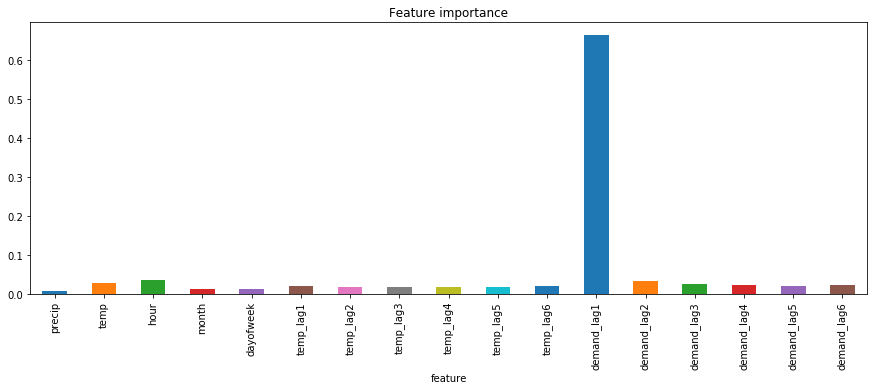

In [11]:
feature_importance = pd.DataFrame.from_dict({'feature':X.columns, 'importance':regr_pipe.named_steps['regr_cv'].best_estimator_.feature_importances_})
feature_importance.plot.bar('feature', 'importance', figsize=(15,5), title='Feature importance', legend=False)
plt.show()